In [1]:
# https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/latest/hand_landmarker.task
import mediapipe as mp
import numpy as np
from mediapipe.framework.formats import landmark_pb2
import cv2

In [2]:
BaseOptions = mp.tasks.BaseOptions
HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

model_path = 'hand_landmarker.task'

# options for landmarker in image mode:
options = mp.tasks.vision.HandLandmarkerOptions(
    base_options=mp.tasks.BaseOptions(model_asset_path=model_path),
    running_mode=mp.tasks.vision.RunningMode.IMAGE,
    min_hand_detection_confidence = 0.2,
    min_hand_presence_confidence = 0.2,
    min_tracking_confidence = 0.2,
    # num_hands=2
)

def close(landmarker):
  landmarker.close()

In [3]:
# Is this still neccesary with just images?
def get_result(result: mp.tasks.vision.HandLandmarkerResult, output_image: mp.Image, timestamp_ms: int):
    return result
    # print(f'hand landmarker result: {result}') 



In [4]:
def draw_landmarks_on_image(rgb_image, detection_result: mp.tasks.vision.HandLandmarkerResult):
    """Courtesy of https://github.com/googlesamples/mediapipe/blob/main/examples/hand_landmarker/python/hand_landmarker.ipynb"""
    global first
    try:
        if detection_result.hand_landmarks == []:
            return rgb_image
        else:
            hand_landmarks_list = detection_result.hand_landmarks
            annotated_image = np.copy(rgb_image)
            
            # Loop through the detected hands to visualize.
            for idx in range(len(hand_landmarks_list)):
                print(hand_landmarks_list[idx])
                hand_landmarks = hand_landmarks_list[idx]
                # Draw the hand landmarks.
                hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
                hand_landmarks_proto.landmark.extend([
                    landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks])
                mp.solutions.drawing_utils.draw_landmarks(
                    annotated_image,
                    hand_landmarks_proto,
                    mp.solutions.hands.HAND_CONNECTIONS,
                    mp.solutions.drawing_styles.get_default_hand_landmarks_style(),
                    mp.solutions.drawing_styles.get_default_hand_connections_style())
                
            return annotated_image
    except Exception as e:
        print(e, 'exception')
        return rgb_image

In [5]:
def detect(image, clazz, landmarker):
    return (landmarker.detect(image=image), clazz)

In [6]:
# load the landmarker
landmarker = mp.tasks.vision.HandLandmarker.create_from_options(options)

# load image
image = mp.Image.create_from_file('./data/American Sign Language Letters.v1-v1.tensorflow/train/M18_jpg.rf.129826d37d00c7e46376752d8649edaa.jpg')

# detect result to draw detected keypoints on frame
detection_result = detect(image, 'A', landmarker)
image_with_landmarks = draw_landmarks_on_image(image.numpy_view(), detection_result[0])

# show frame with keypoints drawn
cv2.imshow('Image', image_with_landmarks)

# stop!
cv2.waitKey(0)
        
#close(landmarker)
#cv2.destroyAllWindows()

RuntimeError: Image decoding failed (can't fopen): ./data/American Sign Language Letters.v1-v1.tensorflow/train/M18_jpg.rf.129826d37d00c7e46376752d8649edaa.jpg

In [12]:
def get_keypoints(landmarker, base_path, file_name, clazz):
    image = mp.Image.create_from_file(base_path + file_name)
    return detect(image, clazz, landmarker)

In [100]:
def create_coord_list(detected_landmarks):
  coord_list = []
  for i in detected_landmarks:
    coord_list.append([i.x, i.y, i.z])
  return coord_list
    
def orthonormal_basis_from_triangle(p1, p2, p3):
    """Return orthonormal triad (e1,e2,e3): e1 along (p2-p1), e2 in the plane, e3 = normal."""
    u = p2 - p1
    v = p3 - p1
    n = np.cross(u, v)
    if np.linalg.norm(n) < 1e-12:
        raise ValueError("Anchor points are collinear; cannot define a plane.")
    e1 = u / np.linalg.norm(u)
    v_perp = v - np.dot(v, e1) * e1
    e2 = v_perp / np.linalg.norm(v_perp)
    e3 = np.cross(e1, e2)  # already unit
    return e1, e2, e3

def solve_affine2d(src_xy, dst_xy):
    """Solve 2D affine mapping (x,y)->(X,Y) from 3 point pairs. Returns 2x2 M and 2-dim t."""
    A, b = [], []
    for (x, y), (X, Y) in zip(src_xy, dst_xy):
        A.append([x, y, 1, 0, 0, 0])
        A.append([0, 0, 0, x, y, 1])
        b += [X, Y]
    A = np.asarray(A, float)
    b = np.asarray(b, float)
    m11, m12, tx, m21, m22, ty = np.linalg.solve(A, b)
    M = np.array([[m11, m12],
                  [m21, m22]], float)
    t = np.array([tx, ty], float)
    return M, t

def normalize_landmarks(points, anchor_idx=(0,5,17), lambda_normal=1.0):
    """
    Build a 3D affine transform (A,t) so that:
      P[i1] -> (0,0,0), P[i2] -> (0,1,0), P[i3] -> (1,1,0),
    and the plane normal maps to the Z axis with scale lambda_normal.
    Returns transformed points (N,3) and (A,t).
    """
    P = np.asarray(points, float)
    i1, i2, i3 = anchor_idx
    p1, p2, p3 = P[i1], P[i2], P[i3]

    # Local orthonormal basis B = [e1 e2 e3]
    e1, e2, e3 = orthonormal_basis_from_triangle(p1, p2, p3)
    B = np.column_stack([e1, e2, e3])          # world <- local
    BT = B.T                                    # local <- world

    # Local coordinates of anchors (q = BT * (p - p1))
    q1 = BT @ (p1 - p1)                         # ~ (0,0,0)
    q2 = BT @ (p2 - p1)                         # (x2, y2, 0)
    q3 = BT @ (p3 - p1)                         # (x3, y3, 0)

    src_xy = np.vstack([q1[:2], q2[:2], q3[:2]])
    dst_xy = np.array([[0.,0.],[0.,1.],[1.,1.]], float)

    # Exact 2D affine that hits the three targets in XY
    M2, t2 = solve_affine2d(src_xy, dst_xy)

    # Compose full 3x3 local linear map: XY via M2, Z via lambda_normal
    L_local = np.array([[M2[0,0], M2[0,1], 0.0],
                        [M2[1,0], M2[1,1], 0.0],
                        [0.0,      0.0,    lambda_normal]], float)

    # Because q1 = (0,0,0) maps to (0,0,0), t2 should be ~0; keep it for completeness
    t_local = np.array([t2[0], t2[1], 0.0], float)

    # Convert to a single world-space affine: P' = A @ P + t
    # q = BT @ (P - p1);  q' = L_local @ q + t_local;  P' = q'  (targets are in world axes)
    A = L_local @ BT
    t = -L_local @ (BT @ p1) + t_local

    # Apply to all points
    normalized_points = (A @ P.T).T + t

    return normalized_points

In [101]:
def store_result(result, clazz, normalize = False):
    d = {}
    if normalize:
        coords = create_coord_list(result.hand_landmarks[0])
        norm_coords = normalize_landmarks(coords)
        for k in range(len(coords)):
            d[str(k)+'_x'] = norm_coords[k][0]
            d[str(k)+'_y'] = norm_coords[k][1]
            d[str(k)+'_z'] = norm_coords[k][2]
    
    else:
        for k,v in enumerate(result.hand_landmarks[0]):
            d[str(k)+'_x'] = v.x
            d[str(k)+'_y'] = v.y
            d[str(k)+'_z'] = v.z
        
    d['clazz'] = clazz
    # print(d)
    return d
    
    # store result values in dict and add to list

In [102]:
# convert list of dicts to pd.df
def get_data_frame(result_list):
    return pd.DataFrame(result_list)

In [103]:
#!pip install pandas==2.1.4 moet numpy <2 gebruiken voor mediapipe!
import pandas as pd
from pathlib import Path

# create the landmarker
landmarker = mp.tasks.vision.HandLandmarker.create_from_options(options)

project_root = Path.cwd().parent
base_dir = project_root / "data" / "American Sign Language Letters.v1-v1.tensorflow" / "train"
csv_path = base_dir / "_annotations.csv"

train_data = pd.read_csv(csv_path)
train_data.head()

train_data[:1]
counter = 0
result_list = []

# loop through images in csv and get results
for i in range(len(train_data)):
    values = train_data[i:i+1][['filename','class']].values[0]
    file_name, clazz = values[0], values[1]
    base_path = base_dir.as_posix() + "/"
    result = get_keypoints(landmarker, base_path, file_name, clazz)
    if len(result[0].hand_landmarks) > 0:
        result_list.append(store_result(result[0], clazz, True))


In [104]:
# Load results into DataFrame
df = get_data_frame(result_list)
df.head()

,0_x,0_y,0_z,1_x,1_y,1_z,2_x,2_y,2_z,3_x,...,18_x,18_y,18_z,19_x,19_y,19_z,20_x,20_y,20_z,clazz
0,4.440892e-16,5.551115e-17,0.0,0.051124,0.418427,-0.116939,0.313114,0.875874,-0.120881,0.753465,...,1.379029,1.422099,-0.037938,1.391361,1.457719,-0.117654,1.287902,1.442976,-0.179995,U
1,4.440892e-16,0.000000e+00,0.0,-0.500712,0.146549,0.124146,-0.302899,0.587342,0.146742,0.139322,...,1.098543,1.203313,0.140969,0.925052,0.970271,0.197545,0.793605,0.783983,0.206605,K
2,-2.220446e-16,-1.110223e-16,0.0,-0.107773,0.357984,-0.172905,0.027341,0.715916,-0.221617,0.429991,...,1.255623,1.418137,-0.058877,1.146578,1.463932,-0.139158,1.010003,1.452090,-0.197155,W
3,-4.440892e-16,4.163336e-17,0.0,-0.135760,0.331438,0.027401,-0.247990,0.688233,0.058299,-0.282595,...,1.096957,1.280970,0.084729,1.021509,1.312750,0.125193,0.935763,1.333853,0.139622,J
4,-4.440892e-16,0.000000e+00,0.0,-0.243716,0.159673,0.093122,-0.370440,0.520758,0.105588,-0.249683,...,1.245612,1.282329,0.034351,1.095569,0.985849,0.062562,0.893829,0.714604,0.071869,M


<class 'pandas.core.series.Series'>
RangeIndex: 1298 entries, 0 to 1297
Series name: clazz
Non-Null Count  Dtype 
--------------  ----- 
1298 non-null   object
dtypes: object(1)
memory usage: 10.3+ KB
None
['U' 'K' 'W' ... 'A' 'W' 'S']
(1298, 2)
[ 1  8  8 ... 15  7 23]


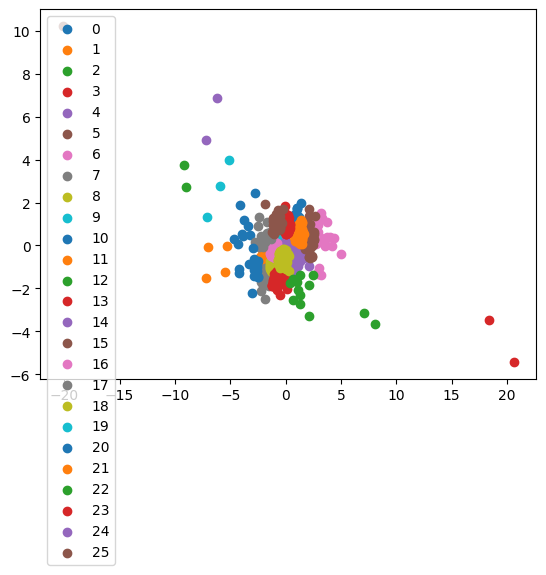

In [96]:
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# split into data and targets
df_training_x = df[['0_x','0_y','0_z','1_x','1_y','1_z','2_x','2_y','2_z'
                    ,'3_x','3_y','3_z','4_x','4_y','4_z','5_x','5_y','5_z'
                    ,'6_x','6_y','6_z','7_x','7_y','7_z','8_x','8_y','8_z'
                    ,'9_x','9_y','9_z','10_x','10_y','10_z','11_x','11_y','11_z'
                    ,'12_x','12_y','12_z','13_x','13_y','13_z','14_x','14_y','14_z'
                    ,'15_x','15_y','15_z','16_x','16_y','16_z','17_x','17_y','17_z'
                    ,'18_x','18_y','18_z','19_x','19_y','19_z','20_x','20_y','20_z'
]]

df_training_y = df['clazz']

# print information for DataFrame
print(df_training_y.info())
print(df_training_y.values)

# reduce dimensions for plotting and plot 26 clusters
pca = PCA(2)
x = pca.fit_transform(df_training_x.values)
print(x.shape)
kmeans = KMeans(n_clusters=26, random_state=42).fit(x) #for 2 Clusters
print(kmeans.labels_)

#Getting unique labels
unique_labels = np.unique(kmeans.labels_)

# plotting results: 
for i in unique_labels:
    plt.scatter(x[kmeans.labels_ == i , 0] , x[kmeans.labels_ == i , 1] , label = i)
plt.legend()
plt.show()

# TODO: assign letters to labels....


In [97]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

X_train = df_training_x.values
y_train = df_training_y.values

logreg = LogisticRegression(max_iter=10000, tol=1e-12).fit(X_train, y_train)

y_pred = logreg.predict(X_train)

print('model fit in {} iterations'.format(logreg.n_iter_[0]))
print('accuracy: {:5.4f}'.format(accuracy_score(y_true=df_training_y, y_pred=logreg.predict(X=df_training_x.values))))
print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=df_training_y, y_pred=logreg.predict(X=df_training_x.values))))

print(classification_report(y_true=y_train, y_pred=y_pred, zero_division=0))

print()

for i in range(len(df_training_x)):
    print(df_training_y.iloc[i], logreg.predict([df_training_x.iloc[i]]))


model fit in 1187 iterations
accuracy: 0.8482
f1: 0.8463
              precision    recall  f1-score   support

           A       0.71      0.91      0.79        64
           B       0.85      1.00      0.92        35
           C       0.79      0.82      0.81        33
           D       0.84      0.82      0.83        50
           E       0.87      0.94      0.91        51
           F       1.00      0.98      0.99        53
           G       0.88      0.94      0.91        49
           H       0.89      0.92      0.90        36
           I       0.83      0.92      0.87        71
           J       0.84      0.58      0.68        71
           K       0.98      0.91      0.94        45
           L       0.91      0.91      0.91        64
           M       0.93      0.84      0.88        45
           N       0.86      0.83      0.85        53
           O       0.67      0.83      0.74        47
           P       0.77      0.85      0.80        39
           Q       0.62 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [98]:
#!pip install session-info

import session_info
session_info.show()

In [99]:
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict

X = df_training_x.values
y = df_training_y.values

# Per-klasse outlier detectie (LOF) met veilige fallback
mask = np.ones(len(X), dtype=bool)

contamination = 0.10
base_neighbors = 20

for c in np.unique(y):
    idx = np.where(y == c)[0]
    Xc = X[idx]
    n_samples_c = len(Xc)

    # te weinig samples => geen LOF (alles inlier laten)
    if n_samples_c < 4:
        continue

    # kies geldige n_neighbors voor deze klasse
    n_neighbors = min(base_neighbors, n_samples_c - 1)
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    pred = lof.fit_predict(Xc)  # -1 outlier, 1 inlier
    mask[idx] = (pred == 1)

"""
    LOF selecteerd de outliers en inliers per klasse o.b.v. een contamination en herkend daarmee 'afwijkend' gedrag.
    Het gevolg hiervan is dat je de dataset kun 'zuiveren' om een verbeterde accuracy te behalen. (wat in sommige gevallen wenselijk is)
    
    Echter, door outliers te detecteren en te verwijderen uit de dataset verlies je ook een bepaalde variatie uit het model in het geval dat het wel een legitiem voorbeeld is.
    Ondanks dat het trainen een verbeterde accuracy geeft zorgt minder variatie dus ook voor minder bergip in het model. (niet wenselijk voor nieuwe cases)
    
    Ik denk daarmee dus dat we het gebruik van outlier detectie/cleaning niet blind moeten gebruiken maar vooral ook moeten inzetten als hulpmiddel.
    Het is wel wenselijk om te voorkomen dat er corrupte beelden of extreme afwijkingen te cleanen, maar het is niet wenselijk om outliers die wél realistische variatie vertonen te cleanen.
"""

X_clean, y_clean = X[mask], y[mask]
print(f"Verwijderd: {np.sum(~mask)} samples ({100*np.mean(~mask):.1f}%).")

def make_cv_for_labels(labels, max_splits=5):
    _, counts = np.unique(labels, return_counts=True)
    min_count = counts.min()
    # we willen minstens 2 folds, maar niet meer dan min_count
    n_splits = max(2, min(max_splits, min_count))
    return StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42), n_splits


# Objectieve vergelijking met CV
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000))

# CV voor raw data
cv_raw, n_raw = make_cv_for_labels(y, max_splits=5)
scores_raw = cross_validate(pipe, X, y, cv=cv_raw, scoring=["accuracy","f1_weighted"])
y_pred_raw_cv = cross_val_predict(pipe, X, y, cv=cv_raw)

# CV voor clean data
cv_clean, n_clean = make_cv_for_labels(y_clean, max_splits=5)
scores_clean = cross_validate(pipe, X_clean, y_clean, cv=cv_clean, scoring=["accuracy","f1_weighted"])
y_pred_clean_cv = cross_val_predict(pipe, X_clean, y_clean, cv=cv_clean)

# ---------- prints ----------
print(f"\nZonder filter (cv folds = {n_raw}) — acc: {scores_raw['test_accuracy'].mean():.3f} ± {scores_raw['test_accuracy'].std():.3f}, "
      f"f1: {scores_raw['test_f1_weighted'].mean():.3f} ± {scores_raw['test_f1_weighted'].std():.3f}")
print("Classification report (Zonder filter):")
print(classification_report(y_true=y, y_pred=y_pred_raw_cv, zero_division=0))

print(f"\nMet LOF-filter (cv folds = {n_clean}) — acc: {scores_clean['test_accuracy'].mean():.3f} ± {scores_clean['test_accuracy'].std():.3f}, "
      f"f1: {scores_clean['test_f1_weighted'].mean():.3f} ± {scores_clean['test_f1_weighted'].std():.3f}")
print("Classification report (Met LOF-filter):")
print(classification_report(y_true=y_clean, y_pred=y_pred_clean_cv, zero_division=0))


Verwijderd: 139 samples (10.7%).

Zonder filter (cv folds = 5) — acc: 0.821 ± 0.024, f1: 0.820 ± 0.024
Classification report (Zonder filter):
              precision    recall  f1-score   support

           A       0.74      0.88      0.80        64
           B       0.97      0.94      0.96        35
           C       0.77      0.73      0.75        33
           D       0.79      0.76      0.78        50
           E       0.94      0.90      0.92        51
           F       0.96      0.92      0.94        53
           G       0.88      0.90      0.89        49
           H       0.81      0.94      0.87        36
           I       0.84      0.86      0.85        71
           J       0.69      0.58      0.63        71
           K       0.98      0.91      0.94        45
           L       0.85      0.86      0.85        64
           M       0.83      0.84      0.84        45
           N       0.84      0.81      0.83        53
           O       0.67      0.68      0.67    

In [63]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

X = df_training_x.values  # genormaliseerde landmark-features
y = df_training_y.values

pipe = make_pipeline(
    StandardScaler(),
    SVC(kernel="rbf", class_weight="balanced")
)

param_dist = {
    "svc__C":     np.logspace(-2, 3, 20),              # 0.01 ... 100
    "svc__gamma": ["scale"] + list(np.logspace(-4, -1, 10))  # 'scale' + 1e-4..1e-1
}

# Nested CV: eerlijke performance (inner: tuning, outer: testen)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

oof_pred = np.empty_like(y, dtype=y.dtype)
accs, f1s = [], []
cm_total = None
labels_all = np.unique(y)
best_params_per_fold = []

for fold, (tr, te) in enumerate(outer_cv.split(X, y), 1):
    Xtr, ytr = X[tr], y[tr]
    Xte, yte = X[te], y[te]

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_dist,
        n_iter=20,
        cv=inner_cv,
        scoring="f1_weighted",
        n_jobs=-1,
        refit=True,
        random_state=42
    )
    search.fit(Xtr, ytr)
    best_clf = search.best_estimator_
    best_params_per_fold.append((search.best_params_, search.best_score_))

    yhat = best_clf.predict(Xte)
    oof_pred[te] = yhat

    acc = accuracy_score(yte, yhat)
    f1w = f1_score(yte, yhat, average="weighted")
    accs.append(acc); f1s.append(f1w)

    print(f"[Fold {fold}] acc={acc:.3f}, f1_w={f1w:.3f}, best={search.best_params_}")

    cm = confusion_matrix(yte, yhat, labels=labels_all)
    cm_total = cm if cm_total is None else cm_total + cm

print("\n Nested-CV samenvatting (zonder LOF)")
print("Accuracy: {:.3f} ± {:.3f}".format(np.mean(accs), np.std(accs)))
print("F1_wght: {:.3f} ± {:.3f}".format(np.mean(f1s), np.std(f1s)))

print("\n Classification report (OOF)")
print(classification_report(y_true=y, y_pred=oof_pred, zero_division=0))

cm_df = pd.DataFrame(cm_total, index=labels_all, columns=labels_all)
print("\n Confusion matrix (OOF, som over folds)")
print(cm_df)

# Eindmodel (beste params op volledige data)
final_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=50,
    cv=outer_cv,
    scoring="f1_weighted",
    n_jobs=-1,
    refit=True,
    random_state=123
)
final_search.fit(X, y)
print("\n Beste SVC op volledige data")
print("Best params:", final_search.best_params_)
print("CV f1_weighted (mean): {:.3f}".format(final_search.best_score_))

final_model = final_search.best_estimator_  # <- gebruik dit om later op nieuwe beelden te voorspellen


C:\Development\ktai assignment-3\ktai-assignment-3-main\.venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Development\ktai assignment-3\ktai-assignment-3-main\.venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


[Fold 1] acc=0.429, f1_w=0.393, best={'svc__gamma': 0.002154434690031882, 'svc__C': 26.366508987303583}


C:\Development\ktai assignment-3\ktai-assignment-3-main\.venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


[Fold 2] acc=0.615, f1_w=0.551, best={'svc__gamma': 0.001, 'svc__C': 162.3776739188721}


C:\Development\ktai assignment-3\ktai-assignment-3-main\.venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


[Fold 3] acc=0.231, f1_w=0.205, best={'svc__gamma': 0.001, 'svc__C': 162.3776739188721}


C:\Development\ktai assignment-3\ktai-assignment-3-main\.venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


[Fold 4] acc=0.308, f1_w=0.236, best={'svc__gamma': 0.021544346900318822, 'svc__C': 0.03359818286283781}


C:\Development\ktai assignment-3\ktai-assignment-3-main\.venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


[Fold 5] acc=0.462, f1_w=0.436, best={'svc__gamma': 0.002154434690031882, 'svc__C': 26.366508987303583}

 Nested-CV samenvatting (zonder LOF)
Accuracy: 0.409 ± 0.132
F1_wght: 0.364 ± 0.129

 Classification report (OOF)
              precision    recall  f1-score   support

           A       0.00      0.00      0.00         1
           B       0.40      0.67      0.50         3
           C       0.40      0.50      0.44         4
           D       0.00      0.00      0.00         1
           F       0.00      0.00      0.00         2
           G       0.60      0.75      0.67         4
           H       0.50      0.50      0.50         2
           I       0.00      0.00      0.00         2
           J       0.00      0.00      0.00         4
           K       0.33      0.33      0.33         3
           M       0.00      0.00      0.00         3
           N       0.00      0.00      0.00         1
           O       1.00      1.00      1.00         3
           P       0.00 

C:\Development\ktai assignment-3\ktai-assignment-3-main\.venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 Beste SVC op volledige data
Best params: {'svc__gamma': 0.004641588833612777, 'svc__C': 7.847599703514606}
CV f1_weighted (mean): 0.454


In [78]:
# split into data and targets
df_training_x = df[['0_x','0_y','0_z','1_x','1_y','1_z','2_x','2_y','2_z'
                    ,'3_x','3_y','3_z','4_x','4_y','4_z','5_x','5_y','5_z'
                    ,'6_x','6_y','6_z','7_x','7_y','7_z','8_x','8_y','8_z'
                    ,'9_x','9_y','9_z','10_x','10_y','10_z','11_x','11_y','11_z'
                    ,'12_x','12_y','12_z','13_x','13_y','13_z','14_x','14_y','14_z'
                    ,'15_x','15_y','15_z','16_x','16_y','16_z','17_x','17_y','17_z'
                    ,'18_x','18_y','18_z','19_x','19_y','19_z','20_x','20_y','20_z'
]]

df_training_y = df['clazz']

normalize_landmarks()

# print information for DataFrame
print(df_training_y.info())
print(df_training_y.values)

# reduce dimensions for plotting and plot 26 clusters
pca = PCA(2)
x = pca.fit_transform(df_training_x.values)
print(x.shape)
kmeans = KMeans(n_clusters=26, random_state=42).fit(x) #for 2 Clusters
print(kmeans.labels_)

#Getting unique labels
unique_labels = np.unique(kmeans.labels_)

# plotting results: 
for i in unique_labels:
    plt.scatter(x[kmeans.labels_ == i , 0] , x[kmeans.labels_ == i , 1] , label = i)
plt.legend()
plt.show()

# TODO: assign letters to labels....

TypeError: normalize_landmarks() missing 1 required positional argument: 'points'